### 분류 모형의 정확도를 평가하기 위한 Precision-Recall curve
-  precision(정밀도)과 recall(재현율) 간의 절충점을 보여주는 그래프
-  곡선 아래의 면적 : ACU-PR
-  곡선 아래의 면적이 클수록 좋은 모형
-  ROC 커브는 0.5에서 점차 증가하여 1에 도달하지만
-  PR 커브는 1.0에서 점차 줄어드는 형태

In [1]:
import pandas as pd
df = pd.read_csv("Data/player.csv")
df.head()

,id,player_name,birthday,preferred_foot,age,height,weight,potential,right_foot,left_foot,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,overall_rating,Label
0,1,Aaron Appindangoye,1992-02-29,right,27,183,187,71,1,0,...,65,69,69,6,11,10,8,8,67,0
1,2,Aaron Cresswell,1989-12-15,right,30,170,146,71,1,0,...,65,69,69,6,11,10,8,8,67,0
2,3,Aaron Doran,1991-05-13,right,28,170,163,66,1,0,...,65,66,69,6,11,10,8,8,62,0
3,4,Aaron Galindo,1982-05-08,right,37,183,198,65,1,0,...,62,63,66,5,10,9,7,7,61,0
4,5,Aaron Hughes,1979-11-08,right,40,183,154,65,1,0,...,62,63,66,5,10,9,7,7,61,0


In [2]:
df.columns

Index(['id', 'player_name', 'birthday', 'preferred_foot', 'age', 'height',
       'weight', 'potential', 'right_foot', 'left_foot', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes',
       'overall_rating', 'Label'],
      dtype='object')

In [3]:
cols = ['age', 'height',
       'weight', 'potential', 'right_foot', 'left_foot', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes',]
x = df[cols]
y = df['Label']
y.value_counts()

Label
1    5705
0    5230
Name: count, dtype: int64

Precision-Recall curve는 주로 불균형 데이터셋의 정밀도와 재현율을 측정하는 지표로 사용되므로 여기서는 샘플링 과정을 생략함

In [4]:
from sklearn.model_selection import train_test_split

x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2,stratify=y, random_state=0)
x_tr.shape, x_ts.shape, y_tr.shape, y_ts.shape

((8748, 39), (2187, 39), (8748,), (2187,))

<Axes: >

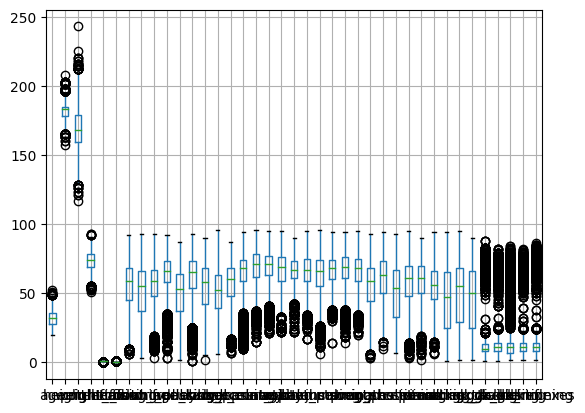

In [5]:
x_tr.boxplot()

In [7]:
from sklearn.preprocessing import RobustScaler
# 중앙값(median) 0, IQR(interquartile range, Q3-Q1) 1이 되도록 변환
# 이상치를 다루기에 더 좋음
scaler = RobustScaler()
scaler.fit(x_tr)
x_tr_scaled = pd.DataFrame(scaler.transform(x_tr))
x_ts_scaled = pd.DataFrame(scaler.transform(x_ts))

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
# svm모형은 데이터의 양이 많을 경우 많은 메모리를 사용하여 속도가 매우 느려질 수 있으므로 BaggingClassifier를 사용하는 것을 권장함

# 1개의 기계학습모형이지만 데이터 샘플을 중복사용하여 서로 다른 결과를 출력하는 다수의 모형을 비교

svm = SVC()
n_estimators = 10
model = BaggingClassifier(base_estimator = svm,   # 분류기
                    n_estimators = n_estimators,  # 분류기수
                    max_samples = 1/n_estimators, # 부트스트랩 
                    n_jobs = -1) 
model.fit(x_tr_scaled, y_tr)
print(model.score(x_tr_scaled, y_tr))
print(model.score(x_ts_scaled, y_ts))

c:\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9245541838134431
0.9218106995884774


In [11]:
from sklearn.metrics import classification_report
pred = model.predict(x_ts_scaled)
print(classification_report(y_ts, pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1046
           1       0.91      0.94      0.93      1141

    accuracy                           0.92      2187
   macro avg       0.92      0.92      0.92      2187
weighted avg       0.92      0.92      0.92      2187



In [12]:
y_score = model.decision_function(x_ts_scaled)
print(y_score)

[-0.06787021  2.45341644  0.84611479 ...  2.81144103 -0.54743011
 -0.69903662]


In [13]:
# 판별함수값으로 구한 precision 평균점수
from sklearn.metrics import average_precision_score
average_precision_score(y_ts, y_score)

0.9827600651737468

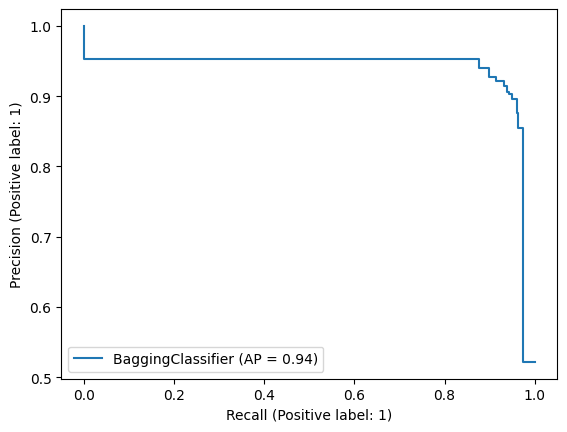

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
disp = PrecisionRecallDisplay.from_estimator(model, x_ts_scaled, y_ts)
plt.show()